In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn');
plt.rcParams['figure.figsize'] =  (16,9)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

In [2]:
# Reading the dataset
bike_rental = pd.read_csv('day.csv')
bike_rental.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [3]:
# Checking the metadata
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Data Cleansing

### 1. Missing Records

In [4]:
# Checking missing records in data
bike_rental.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

So there are **no missing records**. Let's proceed with the next step of cleaning- Data type fix

### 2. Fixing Data types
The data type of `dteday` is object. However, as can be seen from data, it is a date value. So, let's convert it to datetime type

In [5]:
# converting dteday to datetime
bike_rental['dteday'] = pd.to_datetime(bike_rental['dteday'])

In [6]:
bike_rental.head()

instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1 2018-01-01       1   0     1        0        6           0   
1        2 2018-02-01       1   0     1        0        0           0   
2        3 2018-03-01       1   0     1        0        1           1   
3        4 2018-04-01       1   0     1        0        2           1   
4        5 2018-05-01       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

There are some variables which do not have correct data type, *as per the **humanized** values they should assume*. For example, the variable `season` has values 1-4 which isn't intuitive. Let's map such variables to the correct values form given data dictionary.

In [7]:
# Mapping the season values to their names
bike_rental['season'] = bike_rental['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

Similarly, `weathersit` a.k.a. weather situation, `weekday` and `mnth` are also has numeric values which need mapping.

In [8]:
# Mapping weather situation to its name
bike_rental['weathersit'] = bike_rental['weathersit'].map({   1: 'Clear+Partly cloudy',
		2: 'Mist+Cloudy',
		3: 'Light Snow+Rain',
		4: 'Heavy Rain+Thunderstorm'})

In [9]:
bike_rental['weekday'] = bike_rental['weekday'].map({1: 'Monday',2: 'Tuesday',3: 'Wednesday',4:'Thursday',5:'Friday',6:'Saturday',0:'Sunday'})
bike_rental['mnth'] = bike_rental['mnth'].map({1: 'Jan',2: 'Feb',3: 'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

Now all the above variables have been mapped to their proper values. However, let us also convert them to their correct data types.<br /> Since they are having limited number of distinct values, these are clearly categorical in nature. *Let's convert `mnth`, `season`, `weekday`, and `weathersit` to category.*

In [10]:
# Converting to categorical variables
bike_rental['season'] = bike_rental['season'].astype('category')
bike_rental['weathersit'] = bike_rental['weathersit'].astype('category')
bike_rental['weekday'] = bike_rental['weekday'].astype('category')
bike_rental['mnth'] = bike_rental['mnth'].astype('category')

In [11]:
bike_rental.dtypes

instant                int64
dteday        datetime64[ns]
season              category
yr                     int64
mnth                category
holiday                int64
weekday             category
workingday             int64
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

**Now all the columns are in correct data types.**

### 3. Filtering extra columns
`instant` is a variable which is simply a duplicate of index. So we can drop it.

In [12]:
bike_rental.drop(columns='instant', inplace=True)

Now, we see the `dteday` ccolumn which has date. But the `yr` and `mnth` columns are also having similar information. Let's see the years which are present in `dteday`.

In [13]:
bike_rental['dteday'].dt.year.unique()

array([2018, 2019], dtype=int64)

So we see `dteday` contains only 2018 and 2019 data which is in coherence with the data dictionary for `yr` column as well. Both hold only 2018 and 2019 data. Also there is separate `mnth` column so we can drop `dteday`.

In [14]:
bike_rental.drop(columns='dteday', inplace=True)

`casual` and `registered` are two variables which are indictive of the number of users whether they are registered or not. Both are however, captured by the `cnt` variable as well. So we can drop them

In [15]:
bike_rental.drop(columns=['casual','registered'], inplace=True)

In [16]:
bike_rental.head()

season  yr mnth  holiday    weekday  workingday           weathersit  \
0  spring   0  Jan        0   Saturday           0          Mist+Cloudy   
1  spring   0  Jan        0     Sunday           0          Mist+Cloudy   
2  spring   0  Jan        0     Monday           1  Clear+Partly cloudy   
3  spring   0  Jan        0    Tuesday           1  Clear+Partly cloudy   
4  spring   0  Jan        0  Wednesday           1  Clear+Partly cloudy   

        temp     atemp      hum  windspeed   cnt  
0  14.110847  18.18125  80.5833  10.749882   985  
1  14.902598  17.68695  69.6087  16.652113   801  
2   8.050924   9.47025  43.7273  16.636703  1349  
3   8.200000  10.60610  59.0435  10.739832  1562  
4   9.305237  11.46350  43.6957  12.522300  1600

# Exploratory Data Analysis

To begin with, lets see the relation between the different numerical variables

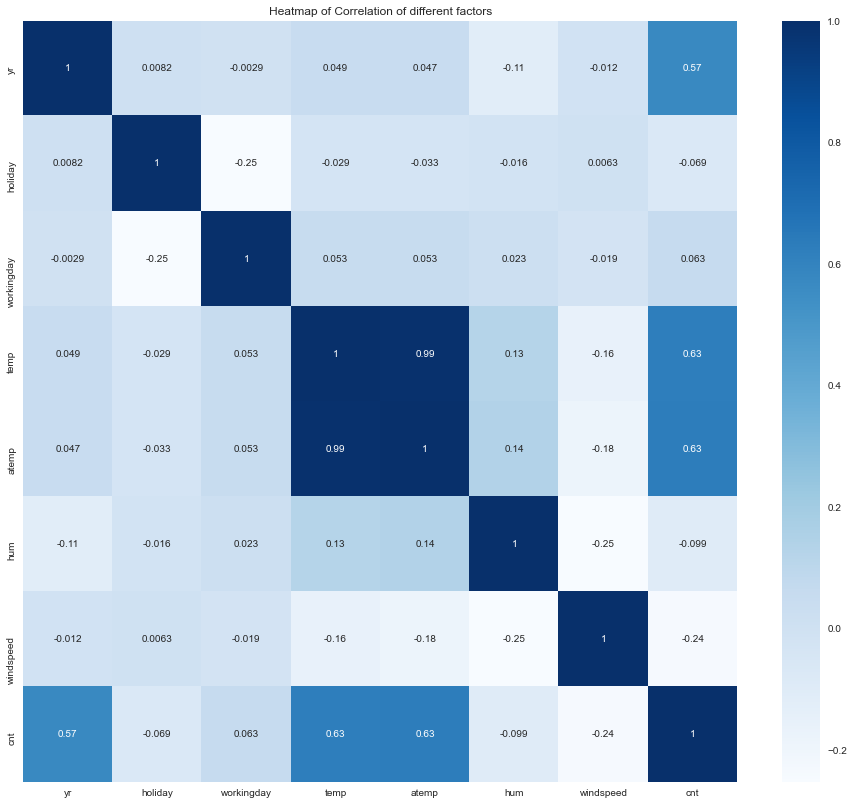

In [17]:
plt.figure(figsize=(16,14))
# plotting the chart
axes = sns.heatmap(data=bike_rental.corr(), cmap='Blues', annot=True);
# Setting title of chart
axes.set(title='Heatmap of Correlation of different factors');

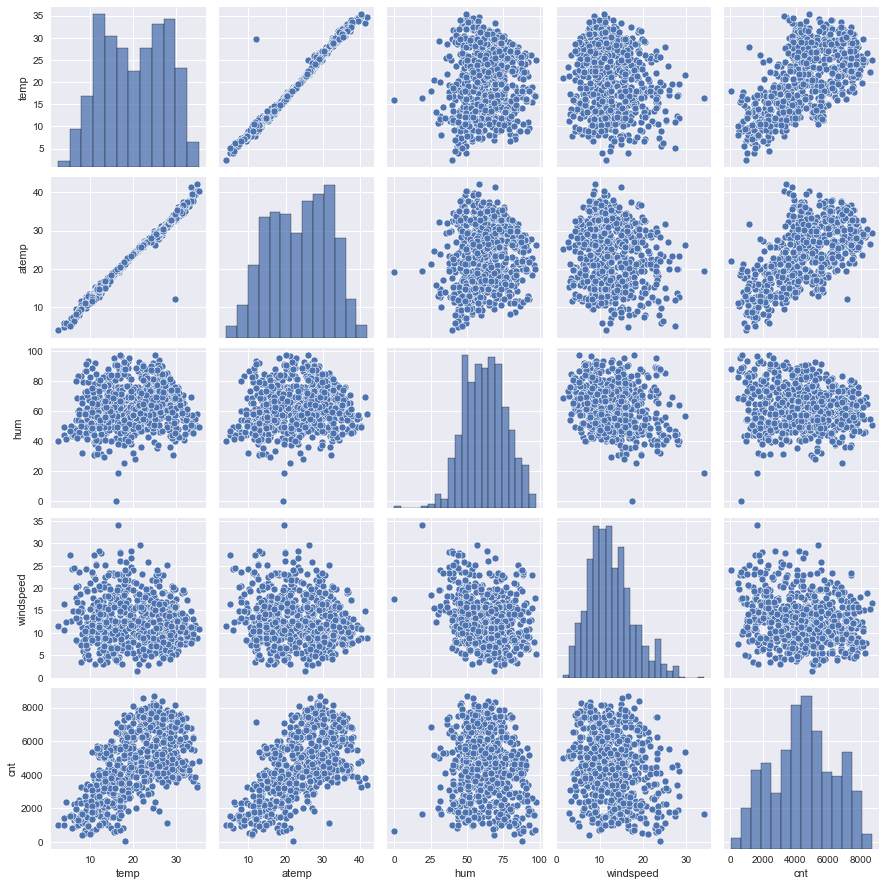

In [18]:
# Creating a chart for checking correlation of all variables
sns.pairplot(data=bike_rental, vars=['temp','atemp','hum', 'windspeed', 'cnt']);

From the plots above, it is clear that:
 - There is a cluster formed between `temp` and `atemp` with correlation 0.99, which indicates a high correlation between the two.
 - `cnt` variable has a good correlation with the `yr`, `temp` and `atemp` variables

Let's now move to analysing the categorica variables. First we will see the value distribution in these categorical variables with respect to count.

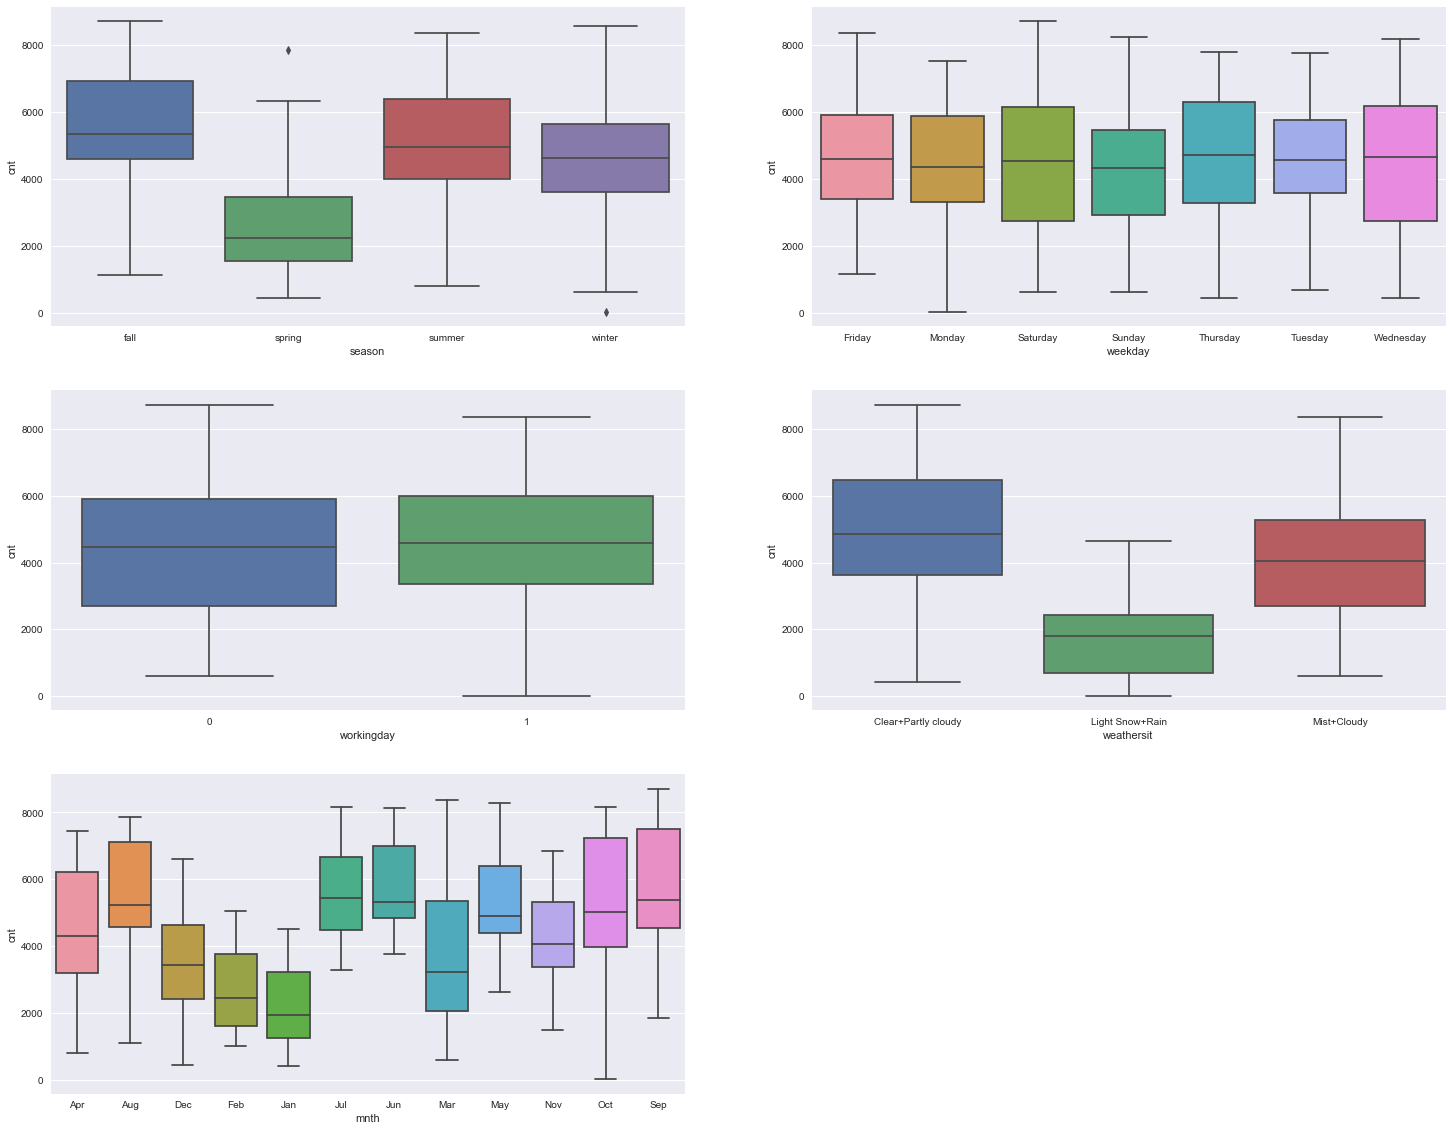

In [19]:
plt.figure(figsize=(25, 20))
# create list of categorical variables
categorical_vars = ['season','weekday','workingday','weathersit','mnth']
for i, category in enumerate(categorical_vars):
    plt.subplot(3,2, i+1)
    # Plotting a box plot for each categorical variable as its value varies with 'cnt'
    sns.boxplot(data=bike_rental, x=category, y='cnt')

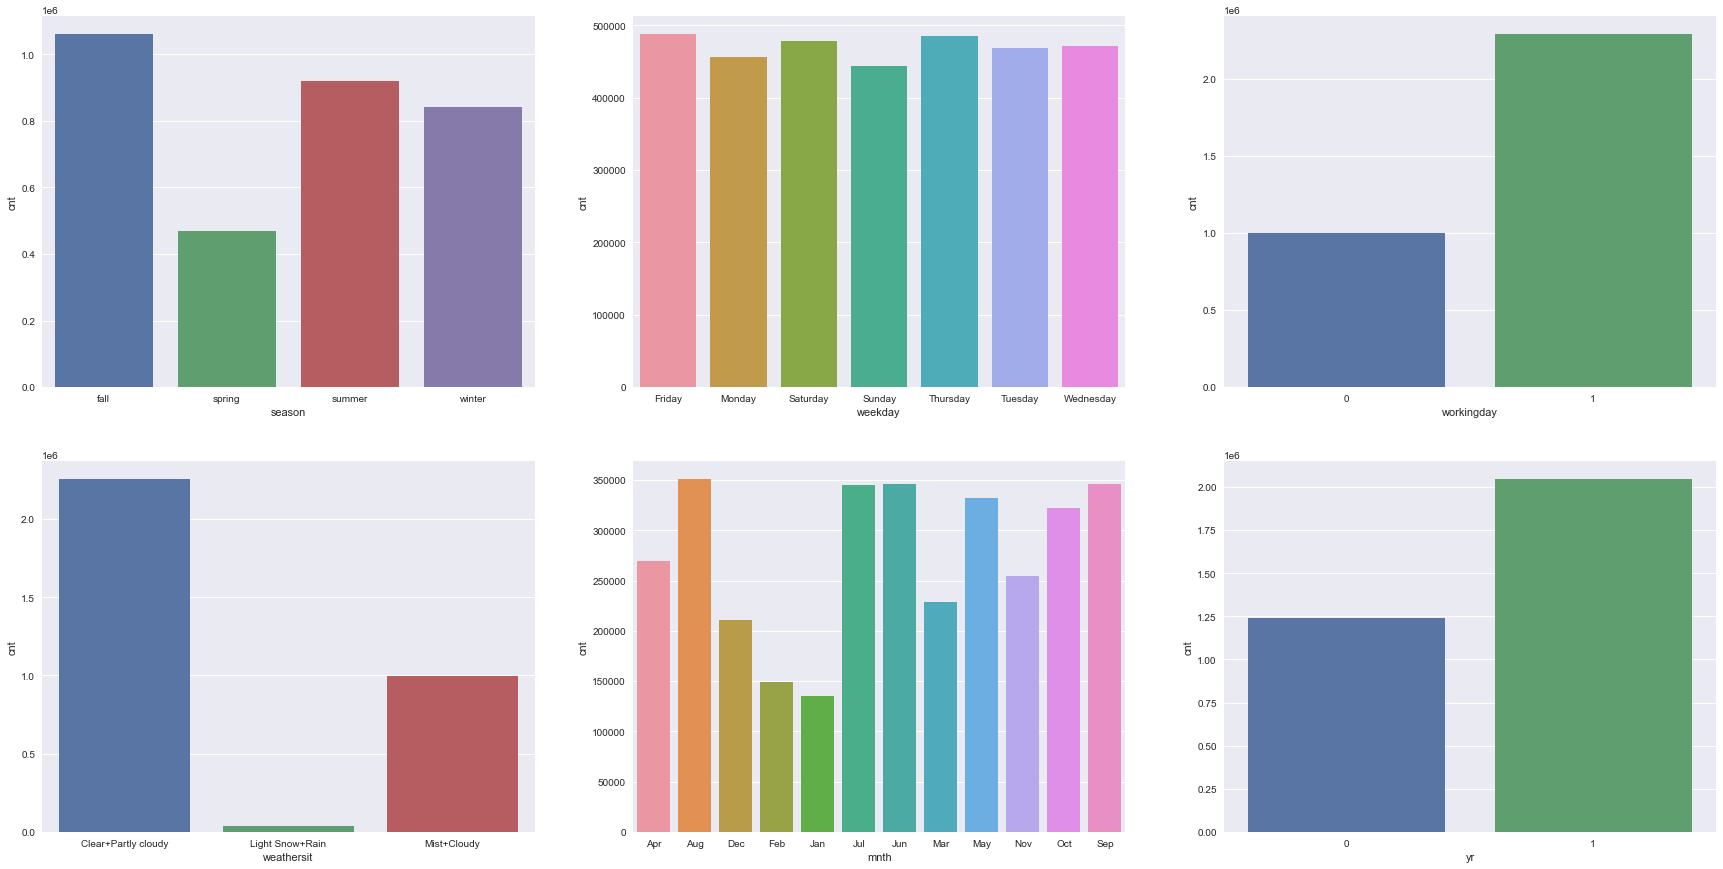

In [20]:
plt.figure(figsize=(30, 15))
# Creating list of categorical variables
categorical_vars = ['season','weekday','workingday','weathersit','mnth','yr']
for i, category in enumerate(categorical_vars):
    plt.subplot(2,3, i+1)
    # Plotting a distribution for each categorical variable 
    sns.barplot(data=bike_rental, x=category, y='cnt', estimator=np.sum, ci=None);

 1. It can be seen from the plot that the fall season is having the most shared bike demands.
2. The demand is relatively the same across all days of the week.
3. On a working day, more people use shared bikes than on a non-working day.
4. On a clear day, the bike demand is huge and much more than a day with light rain or snowfall.
5. Although the demand is varying throughout the year, July, August and September months are having approximately same number of users. This is also higher than other months like Jan, or March.
6. Year 2019 enjoyed an increased number of shared bike demands than 2018.

Since `temp` and `atemp` have very high correlation, we can drop one of them.

In [21]:
bike_rental.drop(columns=['atemp'], inplace=True);

# Data Preparation for Modelling

Let's now create dummy variables for categorical variables since the categorical data cannot be fed to a regression model directly.

In [22]:
# Checking the shape of dataframe
bike_rental.shape

(730, 11)

In [23]:
# Set option to display all columns of dataframe
pd.set_option('display.max_columns', None)
# Creating list of variables to create dummy variables for i.e. list of all categorical variables
dummy_vars = ['season','weathersit','mnth','weekday']
# Inputing dummy variables into the dataset
bike_rental = pd.get_dummies(data=bike_rental, columns=dummy_vars, prefix='', prefix_sep='', drop_first=True)
# Checking the data frame
bike_rental.head()

yr  holiday  workingday       temp      hum  windspeed   cnt  spring  \
0   0        0           0  14.110847  80.5833  10.749882   985       1   
1   0        0           0  14.902598  69.6087  16.652113   801       1   
2   0        0           1   8.050924  43.7273  16.636703  1349       1   
3   0        0           1   8.200000  59.0435  10.739832  1562       1   
4   0        0           1   9.305237  43.6957  12.522300  1600       1   

   summer  winter  Light Snow+Rain  Mist+Cloudy  Aug  Dec  Feb  Jan  Jul  Jun  \
0       0       0                0            1    0    0    0    1    0    0   
1       0       0                0            1    0    0    0    1    0    0   
2       0       0                0            0    0    0    0    1    0    0   
3       0       0                0            0    0    0    0    1    0    0   
4       0       0                0            0    0    0    0    1    0    0   

   Mar  May  Nov  Oct  Sep  Monday  Saturday  Sunday  Thursday  Tuesday  \
0    0    0    0    0    0       0         1       0         0        0   
1    0    0    0    0    0       0         0       1         0        0   
2    0    0    0    0    0       1         0       0         0        0   
3    0    0    0    0    0       0         0       0         0        1   
4    0    0    0    0    0       0         0       0         0        0   

   Wednesday  
0          0  
1          0  
2          0  
3          0  
4          1

# Building Model
1. Splitting into training and test set
2. Feature scaling
3. Training the model
4. Residual analysis and Assumption violation check
5. Testing the model

In [24]:
np.random.seed(0)
# dividing data into testing and training set
TrainingData, TestingData = train_test_split(bike_rental, train_size=0.7, random_state=100)
# Print shape of test and train data
TrainingData.shape, TestingData.shape

((510, 29), (220, 29))

## Feature scaling- MinMaxScaling

In [25]:
#Create scaler object
scaler = MinMaxScaler()
# Create list of numeric variables
num_vars= ['temp','hum','windspeed', 'cnt']
# Fitting And Transforming the variables in Training Set
TrainingData[num_vars] = scaler.fit_transform(TrainingData[num_vars])
# Verifying the scaling operation
TrainingData[num_vars].describe()

temp         hum   windspeed         cnt
count  510.000000  510.000000  510.000000  510.000000
mean     0.537440    0.650480    0.320883    0.513499
std      0.225858    0.145846    0.169803    0.224421
min      0.000000    0.000000    0.000000    0.000000
25%      0.339853    0.538643    0.199179    0.356420
50%      0.542596    0.653714    0.296763    0.518638
75%      0.735215    0.754830    0.414447    0.684710
max      1.000000    1.000000    1.000000    1.000000

We see that **all the 4 variables are now within (0,1) range**. So they have been scaled. Now we can proceed with training the model.

## Training a model
To train a model, let's first segregate the target and predictors variables. Then we will try to chop down to top 15 features using automated approach (RFE). Later, we will manually take decisions on which variable to keep and which one to drop from model based on the stats of the model.

In [26]:
TrainingDataCpy = TrainingData.copy()

In [27]:
# Take out target variable and put in y_train
y_train = TrainingData.pop('cnt')
# Designate remaining variables as predictors
X_train = TrainingData

In [28]:
'''
Function to train model with Statsmodels APi, given the columns to add or drop.
'''
def train_model(predictor_data, target_data, columns, operation):
    if not operation: 
        # Raise Exception if operation is not provided
        raise Exception('Operation required')
    
    if operation and operation.lower() !='add' and operation.lower() != 'drop': 
        # Raise error if operation is neither add or drop
        raise ValueError('Unknown operation value')
    if operation.lower() =='drop':
        # Drop the variables from given predictor set
        predictor_data.drop(columns=columns, inplace=True)
    if operation.lower() == 'add':
        # Take out existing variables
        existing_cols = list(predictor_data.columns)
        # Add given predictor
        existing_cols.extend(columns)
        # Take subset of training data with above variables/predictors
        predictor_data = X_train[existing_cols]
    # Add constant
    X_train_sm = sm.add_constant(predictor_data)
    # Fit the model on the predictor data
    model = sm.OLS(target_data, X_train_sm).fit()
    
    return model, predictor_data, X_train_sm

In [29]:
'''
Function to calculate VIFs for all the variables of given dataset
'''
def calc_VIF(data):
    # Create empty dataframe
    vif_table = pd.DataFrame()
    # Create column of variable names present in dataset
    vif_table['Features'] = data.columns
    # Calculate variance inflation factor for multicollinearity check
    vif_table['VIF'] = [variance_inflation_factor(data.values, idx) for idx in range(data.shape[1])]
    # Sort the VIF in descending order
    return vif_table.sort_values(by='VIF', ascending=False)

In [30]:
bike_rental.shape

(730, 29)

We can see that there are 30 variables in the dataset. To train the model, we need to filter out the variables which are driving the bike service demands. Lets **start with RFE** now.

In [31]:
# Create Linear Regression object from sci-kit learn
lr = LinearRegression()
# Fit a model over training data
model = lr.fit(X_train, y_train)
# Create a RFE object with configuration of given LR model, and 15 as top feature count
rfe = RFE(model, 15)
# Fit the RFE to calculate the top 15 features
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

Now that RFE is fitted to the dataset, let's see the results of RFE - which variables it has given a priority.

In [32]:
# Create a list of variables with corresponding RFE support/verdict and rank
feature_ranks = list(zip(X_train.columns, rfe.support_, rfe.ranking_))
# Sort the variables in reverse order
feature_ranks.sort(key=lambda x: x[1], reverse=True)
# Print
feature_ranks

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Light Snow+Rain', True, 1),
 ('Mist+Cloudy', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Sep', True, 1),
 ('Saturday', True, 1),
 ('Aug', False, 6),
 ('Dec', False, 3),
 ('Feb', False, 4),
 ('Jun', False, 13),
 ('Mar', False, 14),
 ('May', False, 5),
 ('Nov', False, 2),
 ('Oct', False, 12),
 ('Monday', False, 8),
 ('Sunday', False, 7),
 ('Thursday', False, 10),
 ('Tuesday', False, 9),
 ('Wednesday', False, 11)]

In [33]:
# Filter list of columns which RFE supported
cols = X_train.columns[rfe.support_]
# Select only those features that RFE supported
X_train_rfe = X_train[cols]
# Create a copy of all 15 variables from training data that RFE supported 
X_train_rfe_cpy = X_train_rfe.copy()

In [34]:
# Add constant
X_train_rfe_sm = sm.add_constant(X_train_rfe)
# Create a model with the available predictor and target variables
model1 = sm.OLS(y_train, X_train_rfe_sm).fit()
# Display model results
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          4.22e-191
Time:                        21:01:01   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2519      0.036      6.969      0.000       0.181       0.323
yr                  0.2305      0.008     28.795      0.000       0.215       0.246
holiday            -0.0582      0.027     -2.164      0.031      -0.111      -0.005
workingday          0.0433      0.012      3.762      0.000       0.021       0.066
temp                0.5096      0.034     14.837      0.000       0.442       0.577
hum                -0.1563      0.037     -4.188      0.000      -0.230      -0.083
windspeed          -0.1863      0.025     -7.310      0.000      -0.236      -0.136
spring             -0.0509      0.021     -2.464      0.014      -0.091      -0.010
summer              0.0508      0.015      3.423      0.001       0.022       0.080
winter              0.0933      0.017      5.403      0.000       0.059       0.127
Light Snow+Rain    -0.2475      0.026     -9.507      0.000      -0.299      -0.196
Mist+Cloudy        -0.0563      0.010     -5.439      0.000      -0.077      -0.036
Jan                -0.0345      0.017     -1.989      0.047      -0.069      -0.000
Jul                -0.0529      0.018     -2.931      0.004      -0.088      -0.017
Sep                 0.0814      0.016      4.945      0.000       0.049       0.114
Saturday            0.0536      0.014      3.694      0.000       0.025       0.082
==============================================================================
Omnibus:                       66.260   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.826
Skew:                          -0.678   Prob(JB):                     1.97e-35
Kurtosis:                       5.383   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As the summary states, the  R<sup>2</sup> and Adjusted R<sup>2</sup> values for this model are very good- 0.848 and 0.844. <br/>
The p-values of all the variables are <0.05 which indicate that all are significant.<br />
However, let's now check for VIF of all features.

In [35]:
# Calculate the VIF of available variables
calc_VIF(X_train_rfe)

Features        VIF
4               hum  29.370804
3              temp  17.780645
2        workingday   5.306978
5         windspeed   4.728655
6            spring   4.531273
8            winter   3.460305
7            summer   2.849835
10      Mist+Cloudy   2.288222
0                yr   2.088739
14         Saturday   1.975769
11              Jan   1.673632
12              Jul   1.592029
13              Sep   1.389751
9   Light Snow+Rain   1.244703
1           holiday   1.176531

Clearly, the VIF of certain variables is a lot higher than the limit. The acceptable range is 1 to 5. The lower the better. <br/>
So we need to drop variable `hum` first.

In [36]:
# Add 'hum' to list of dropped variables from top 15 chosen by RFE
dropped_vars = ['hum']
# Create a model with the available predictor and target variables after dropping 'hum'
model2, X_train_rfe, X_train_rfe_sm = train_model(X_train_rfe, y_train, columns=['hum'], operation='drop')
# Display model results
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          1.60e-188
Time:                        21:01:02   Log-Likelihood:                 510.75
No. Observations:                 510   AIC:                            -991.5
Df Residuals:                     495   BIC:                            -928.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1737      0.031      5.520      0.000       0.112       0.235
yr                  0.2345      0.008     29.009      0.000       0.219       0.250
holiday            -0.0558      0.027     -2.042      0.042      -0.109      -0.002
workingday          0.0464      0.012      3.966      0.000       0.023       0.069
temp                0.4722      0.034     14.005      0.000       0.406       0.538
windspeed          -0.1563      0.025     -6.286      0.000      -0.205      -0.107
spring             -0.0599      0.021     -2.867      0.004      -0.101      -0.019
summer              0.0445      0.015      2.967      0.003       0.015       0.074
winter              0.0784      0.017      4.562      0.000       0.045       0.112
Light Snow+Rain    -0.2908      0.024    -11.977      0.000      -0.339      -0.243
Mist+Cloudy        -0.0813      0.009     -9.437      0.000      -0.098      -0.064
Jan                -0.0392      0.018     -2.227      0.026      -0.074      -0.005
Jul                -0.0479      0.018     -2.614      0.009      -0.084      -0.012
Sep                 0.0755      0.017      4.527      0.000       0.043       0.108
Saturday            0.0583      0.015      3.968      0.000       0.029       0.087
==============================================================================
Omnibus:                       67.830   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.565
Skew:                          -0.692   Prob(JB):                     1.84e-36
Kurtosis:                       5.415   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model is performing nearly as good as our previous model.

In [37]:
# Calculate the VIF of available variables
calc_VIF(X_train_rfe)

Features       VIF
3              temp  7.070219
2        workingday  5.243195
4         windspeed  4.675805
5            spring  3.074591
6            summer  2.340269
0                yr  2.075193
7            winter  1.977789
13         Saturday  1.968247
10              Jan  1.621723
11              Jul  1.591949
9       Mist+Cloudy  1.579492
12              Sep  1.347336
1           holiday  1.174038
8   Light Snow+Rain  1.085783

Now we can see that VIF for `temp` is more than 5. So let's drop this variable.

In [38]:
# Add 'temp' to list of dropped variables from top 15 chosen by RFE
dropped_vars.append('temp')
# Create a model with the available predictor and target variables after dropping 'temp'
model3, X_train_rfe, X_train_rfe_sm = train_model(X_train_rfe, y_train, columns=['temp'], operation='drop')
# Display model results
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     135.7
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          6.44e-154
Time:                        21:01:02   Log-Likelihood:                 425.63
No. Observations:                 510   AIC:                            -823.3
Df Residuals:                     496   BIC:                            -764.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5444      0.020     27.118      0.000       0.505       0.584
yr                  0.2478      0.009     26.153      0.000       0.229       0.266
holiday            -0.0567      0.032     -1.757      0.080      -0.120       0.007
workingday          0.0478      0.014      3.466      0.001       0.021       0.075
windspeed          -0.1878      0.029     -6.426      0.000      -0.245      -0.130
spring             -0.2602      0.018    -14.483      0.000      -0.296      -0.225
summer             -0.0427      0.016     -2.651      0.008      -0.074      -0.011
winter             -0.0762      0.016     -4.903      0.000      -0.107      -0.046
Light Snow+Rain    -0.3034      0.029    -10.593      0.000      -0.360      -0.247
Mist+Cloudy        -0.0882      0.010     -8.688      0.000      -0.108      -0.068
Jan                -0.1026      0.020     -5.112      0.000      -0.142      -0.063
Jul                -0.0095      0.021     -0.446      0.656      -0.052       0.032
Sep                 0.0710      0.020      3.610      0.000       0.032       0.110
Saturday            0.0562      0.017      3.243      0.001       0.022       0.090
==============================================================================
Omnibus:                       34.639   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.598
Skew:                          -0.421   Prob(JB):                     3.46e-15
Kurtosis:                       4.557   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that R<sup>2</sup> and Adjusted R<sup>2</sup> values of the model has decreased. But moreover, the p-values of some variables(Jul, holiday) has gone up. <br/>
Let's check the effect on VIFs as well.

In [39]:
# Calculate the VIF of available variables
calc_VIF(X_train_rfe)

Features       VIF
3         windspeed  4.272014
2        workingday  3.827313
4            spring  2.969114
5            summer  2.287378
6            winter  1.976533
0                yr  1.913084
12         Saturday  1.689847
9               Jan  1.597797
8       Mist+Cloudy  1.568281
10              Jul  1.297993
11              Sep  1.247749
1           holiday  1.131823
7   Light Snow+Rain  1.084551

We can see all variables' VIF is lower than 5 so they are in acceptable range. However, we need to drop variables which are insignificant. <br/>
We will go ahead and drop `Jul` since it has the highest p-value

In [40]:
# Add 'Jul' to list of dropped variables from top 15 chosen by RFE
dropped_vars.append('Jul')
# Create a model with the available predictor and target variables after dropping 'Jul'
model4, X_train_rfe, X_train_rfe_sm = train_model(X_train_rfe, y_train, columns=['Jul'], operation='drop')
# Display model results
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     147.2
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          5.73e-155
Time:                        21:01:02   Log-Likelihood:                 425.53
No. Observations:                 510   AIC:                            -825.1
Df Residuals:                     497   BIC:                            -770.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5406      0.018     29.655      0.000       0.505       0.576
yr                  0.2478      0.009     26.179      0.000       0.229       0.266
holiday            -0.0563      0.032     -1.746      0.081      -0.120       0.007
workingday          0.0481      0.014      3.489      0.001       0.021       0.075
windspeed          -0.1877      0.029     -6.429      0.000      -0.245      -0.130
spring             -0.2568      0.016    -15.797      0.000      -0.289      -0.225
summer             -0.0393      0.014     -2.768      0.006      -0.067      -0.011
winter             -0.0730      0.014     -5.303      0.000      -0.100      -0.046
Light Snow+Rain    -0.3035      0.029    -10.606      0.000      -0.360      -0.247
Mist+Cloudy        -0.0879      0.010     -8.685      0.000      -0.108      -0.068
Jan                -0.1027      0.020     -5.118      0.000      -0.142      -0.063
Sep                 0.0737      0.019      3.933      0.000       0.037       0.111
Saturday            0.0564      0.017      3.254      0.001       0.022       0.090
==============================================================================
Omnibus:                       34.767   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.525
Skew:                          -0.424   Prob(JB):                     3.58e-15
Kurtosis:                       4.553   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's calculate VIFs as well.

In [41]:
# Calculate the VIF of available variables
calc_VIF(X_train_rfe)

Features       VIF
3         windspeed  4.119343
2        workingday  3.537338
4            spring  2.684481
5            summer  2.012870
0                yr  1.888419
6            winter  1.775321
11         Saturday  1.620428
9               Jan  1.597323
8       Mist+Cloudy  1.568069
10              Sep  1.201263
1           holiday  1.125730
7   Light Snow+Rain  1.084541

Even after dropping `Jul`, the Adjusted R<sup>2</sup> value remains the same. VIF of all variables are within the acceptable range. But p-value of `holiday` is more than 0.05. Hence, this variable needs to be dropped.

In [42]:
# Add 'holiday' to list of dropped variables from top 15 chosen by RFE
dropped_vars.append('holiday')
# Create a model with the available predictor and target variables after dropping 'holiday'
model5, X_train_rfe, X_train_rfe_sm = train_model(X_train_rfe, y_train, columns=['holiday'], operation='drop')
# Display model results
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     159.7
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          2.01e-155
Time:                        21:01:03   Log-Likelihood:                 423.97
No. Observations:                 510   AIC:                            -823.9
Df Residuals:                     498   BIC:                            -773.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5332      0.018     30.023      0.000       0.498       0.568
yr                  0.2480      0.009     26.146      0.000       0.229       0.267
workingday          0.0564      0.013      4.353      0.000       0.031       0.082
windspeed          -0.1887      0.029     -6.450      0.000      -0.246      -0.131
spring             -0.2581      0.016    -15.860      0.000      -0.290      -0.226
summer             -0.0394      0.014     -2.768      0.006      -0.067      -0.011
winter             -0.0743      0.014     -5.392      0.000      -0.101      -0.047
Light Snow+Rain    -0.3023      0.029    -10.546      0.000      -0.359      -0.246
Mist+Cloudy        -0.0874      0.010     -8.623      0.000      -0.107      -0.067
Jan                -0.1033      0.020     -5.138      0.000      -0.143      -0.064
Sep                 0.0715      0.019      3.815      0.000       0.035       0.108
Saturday            0.0648      0.017      3.887      0.000       0.032       0.098
==============================================================================
Omnibus:                       39.401   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.660
Skew:                          -0.459   Prob(JB):                     5.04e-18
Kurtosis:                       4.705   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, **all variables are significant (p-value < 0.05)**. Let's check VIF as well.

In [43]:
# Calculate the VIF of available variables
calc_VIF(X_train_rfe)

Features       VIF
2         windspeed  4.041735
1        workingday  3.293074
3            spring  2.648377
4            summer  1.998198
0                yr  1.881943
5            winter  1.727584
8               Jan  1.596358
7       Mist+Cloudy  1.568068
10         Saturday  1.558577
9               Sep  1.180988
6   Light Snow+Rain  1.083720

VIf is also <5. <br/>

**So, we have got a model which has R<sup>2</sup> 0.779 and Adjusted R<sup>2</sup> 0.774 which is a pretty good model. <br/>**
However, let's try to bring down the multicollinearity of the model a bit more. We will target to keep the VIF <3 now and see if we can get a model that has the similar performance and with more independence among features.

Let's drop the `windspeed` variable since it has the highest VIF among the independent variables.

In [44]:
# Add 'windspeed' to list of dropped variables from top 15 chosen by RFE
dropped_vars.append('windspeed')
# Create a model with the available predictor and target variables after dropping 'windspeed'
model6, X_train_rfe, X_train_rfe_sm = train_model(X_train_rfe, y_train, columns=['windspeed'], operation='drop')
# Display model results
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     158.6
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          6.65e-148
Time:                        21:01:03   Log-Likelihood:                 403.50
No. Observations:                 510   AIC:                            -785.0
Df Residuals:                     499   BIC:                            -738.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4819      0.017     29.184      0.000       0.449       0.514
yr                  0.2470      0.010     25.048      0.000       0.228       0.266
workingday          0.0577      0.013      4.288      0.000       0.031       0.084
spring             -0.2828      0.016    -17.197      0.000      -0.315      -0.251
summer             -0.0551      0.015     -3.777      0.000      -0.084      -0.026
winter             -0.0780      0.014     -5.452      0.000      -0.106      -0.050
Light Snow+Rain    -0.3209      0.030    -10.819      0.000      -0.379      -0.263
Mist+Cloudy        -0.0860      0.011     -8.161      0.000      -0.107      -0.065
Jan                -0.0889      0.021     -4.282      0.000      -0.130      -0.048
Sep                 0.0765      0.019      3.933      0.000       0.038       0.115
Saturday            0.0619      0.017      3.571      0.000       0.028       0.096
==============================================================================
Omnibus:                       45.587   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.173
Skew:                          -0.467   Prob(JB):                     1.19e-24
Kurtosis:                       5.076   Cond. No.                         8.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# Calculate the VIF of available variables
calc_VIF(X_train_rfe)

Features       VIF
1       workingday  2.895895
2           spring  2.168097
0               yr  1.828869
3           summer  1.711368
4           winter  1.586988
7              Jan  1.578478
6      Mist+Cloudy  1.566200
9         Saturday  1.437239
8              Sep  1.172428
5  Light Snow+Rain  1.072336

All the variables selected by the model are significant (p-value = 0). <br/>
VIF is in limit 3. *However our model performance has also marginally **decreased.** *<br/>

So we will try adding `temp` back, since it had a good correlation (0.63) with `cnt`.

In [46]:
# Remove 'temp' from list of dropped variables, top 15 chosen by RFE
dropped_vars.remove('temp')
# Create a model with the available predictor and target variables after adding back 'temp'
model7, X_train_rfe, X_train_rfe_sm = train_model(X_train_rfe, y_train, columns=['temp'], operation='add')
# Display model results
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     215.9
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          1.61e-181
Time:                        21:01:03   Log-Likelihood:                 485.77
No. Observations:                 510   AIC:                            -947.5
Df Residuals:                     498   BIC:                            -896.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1000      0.031      3.217      0.001       0.039       0.161
yr                  0.2338      0.008     27.650      0.000       0.217       0.250
workingday          0.0566      0.011      4.937      0.000       0.034       0.079
spring             -0.0616      0.021     -2.891      0.004      -0.104      -0.020
summer              0.0498      0.015      3.414      0.001       0.021       0.078
winter              0.0924      0.017      5.320      0.000       0.058       0.127
Light Snow+Rain    -0.3055      0.025    -12.079      0.000      -0.355      -0.256
Mist+Cloudy        -0.0780      0.009     -8.672      0.000      -0.096      -0.060
Jan                -0.0273      0.018     -1.493      0.136      -0.063       0.009
Sep                 0.0911      0.017      5.485      0.000       0.058       0.124
Saturday            0.0647      0.015      4.378      0.000       0.036       0.094
temp                0.4786      0.035     13.770      0.000       0.410       0.547
==============================================================================
Omnibus:                       79.357   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.461
Skew:                          -0.771   Prob(JB):                     1.21e-46
Kurtosis:                       5.752   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Calculate the VIF of available variables
calc_VIF(X_train_rfe)

Features       VIF
10             temp  4.801251
1        workingday  4.657491
2            spring  2.204054
0                yr  2.071055
9          Saturday  1.818722
3            summer  1.751840
7               Jan  1.604588
4            winter  1.587766
6       Mist+Cloudy  1.575688
8               Sep  1.228076
5   Light Snow+Rain  1.072368

It is worth noticing that the model performance has significantly improved over our last model. R<sup>2</sup> has increased to 0.827 and Adjusted R<sup>2</sup> has increased to 0.823. The VIFs for some variables has gone up, but is still in acceptable range (< 5). <br/>However, with addition of `temp`, the p-value of `Jan` has now grown to more than 0.05.<br />
So we will remove `Jan` now that is insignificant.

In [48]:
# Add 'Jan' to list of dropped variables from top 15 chosen by RFE
dropped_vars.append('Jan')
# Create a model with the available predictor and target variables after dropping 'Jan'
model8, X_train_rfe, X_train_rfe_sm = train_model(X_train_rfe, y_train, columns=['Jan'], operation='drop')
# Display model results
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     236.7
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          3.10e-182
Time:                        21:01:03   Log-Likelihood:                 484.63
No. Observations:                 510   AIC:                            -947.3
Df Residuals:                     499   BIC:                            -900.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0902      0.030      2.964      0.003       0.030       0.150
yr                  0.2334      0.008     27.580      0.000       0.217       0.250
workingday          0.0566      0.011      4.924      0.000       0.034       0.079
spring             -0.0650      0.021     -3.060      0.002      -0.107      -0.023
summer              0.0527      0.014      3.642      0.000       0.024       0.081
winter              0.0970      0.017      5.666      0.000       0.063       0.131
Light Snow+Rain    -0.3041      0.025    -12.017      0.000      -0.354      -0.254
Mist+Cloudy        -0.0786      0.009     -8.743      0.000      -0.096      -0.061
Sep                 0.0916      0.017      5.508      0.000       0.059       0.124
Saturday            0.0645      0.015      4.365      0.000       0.035       0.094
temp                0.4914      0.034     14.564      0.000       0.425       0.558
==============================================================================
Omnibus:                       77.597   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.504
Skew:                          -0.754   Prob(JB):                     1.44e-45
Kurtosis:                       5.728   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, the model performance R<sup>2</sup> and Adjusted R<sup>2</sup> is now 0.826 and 0.822 respectively. Also, all the variables are significant now. Let's check VIF for features now.

In [49]:
# Calculate the VIF of available variables
calc_VIF(X_train_rfe)

Features       VIF
9             temp  4.723123
1       workingday  4.634094
0               yr  2.066406
8         Saturday  1.812299
3           summer  1.751806
2           spring  1.702641
4           winter  1.587441
6      Mist+Cloudy  1.567088
7              Sep  1.227643
5  Light Snow+Rain  1.071640

All VIF are also acceptable (< 5). <br/> So this is a better model than our previous one and we will proceed with this one.
### Let's now check if the model violates any assumption or not.

## Residual Analysis
One of the assumptions one of the assumption of the linear regression is that the error terms should be normally distributed with mean equal to 0. So we will verify if our model is not violating this assumption. We will plot a histogram of the error terms to check whether they are normally distributed.

### 1. Checking for normality of residuals

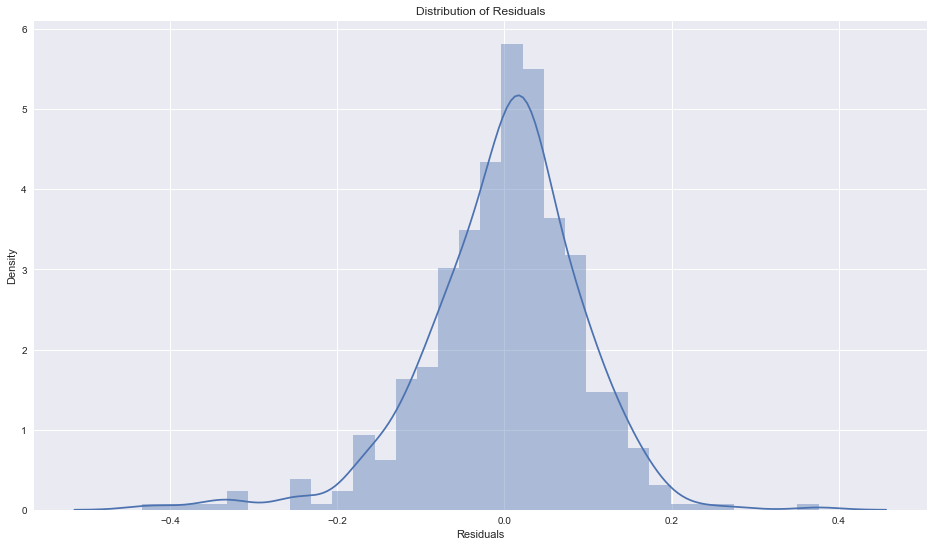

In [50]:
# Predicting the outcome from the training dataset
y_train_pred = model8.predict(X_train_rfe_sm)
# Calculating the errors between actual and predicted values
residuals = y_train - y_train_pred
# Plotting distribution of errors
axes = sns.distplot(residuals)
# Setting title and axes labels of chart
axes.set(title='Distribution of Residuals', xlabel='Residuals');

So we can see that the residuals or errors are normally distributed as per the assumptions of linear regression.

### 2. Checking for Homoscedasticity
The residuals/errors should not be having any change in variance. So we plot a scatter plot and see if this is the case.

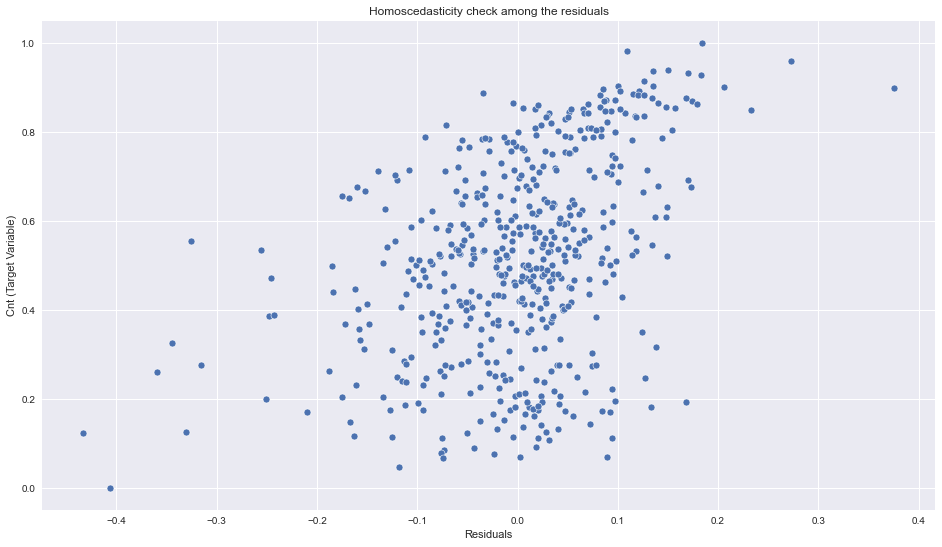

In [51]:
# Plotting the residuals against target variable
axes = sns.scatterplot(residuals, y_train);
# Setting title and axes labels of chart
axes.set(title='Homoscedasticity check among the residuals', xlabel='Residuals', ylabel='Cnt (Target Variable)');

Since there is no evident pattern in the residuals, we can say this assumption is preserved.

### 3. Absence of AutoCorrelation
Absence of auto-correlation can be verified by **Durbin-Watson test**. This test is *automatically performed by statsmodel during training* so we can refer to the summary of the final model for test results.

In [52]:
model8.summary().tables[2]

<class 'statsmodels.iolib.table.SimpleTable'>

The result of the test is 2.069 (very close to 2). Hence we can say the autocorrelation is not present (or present at minimal) among the residuals.

### 4. Absence of Multicollinearity
Multicollinearity can be a big issue in case of Linear Regression if introduced into the model. To check for this, we check the Variance Inflation Factors of the final variables in the model.

In [53]:
calc_VIF(X_train_rfe)

Features       VIF
9             temp  4.723123
1       workingday  4.634094
0               yr  2.066406
8         Saturday  1.812299
3           summer  1.751806
2           spring  1.702641
4           winter  1.587441
6      Mist+Cloudy  1.567088
7              Sep  1.227643
5  Light Snow+Rain  1.071640

Since the VIF for all features is less than 5, we can say multicollinearity is not an issue with the model. <br/>
### So we can proceed ahead and test our model on unseen data. 

## Testing the model
For testing the model, we need to scale it first, so that the coefficients learnt by the model for training data can be used over the testing data as well.

In [54]:
# Scaling the numeric variables in Testing data using pre-fitted scaler
TestingData[num_vars] = scaler.transform(TestingData[num_vars])

In [55]:
# Take out the target variable and put in y_test
y_test = TestingData.pop('cnt')
# Designate the remaining variables as Test predictors
X_test = TestingData

In [56]:
# Get subset of Test data with only the variables finallised post modelling
X_test = X_test[list(X_train_rfe.columns)]

In [57]:
# Add constant
X_test_sm = sm.add_constant(X_test)
# Predicting the outcome from the test dataset
y_test_pred = model8.predict(X_test_sm)

## Evaluating the model
Now that we have the predictions done on test set, we can evaluate our model.

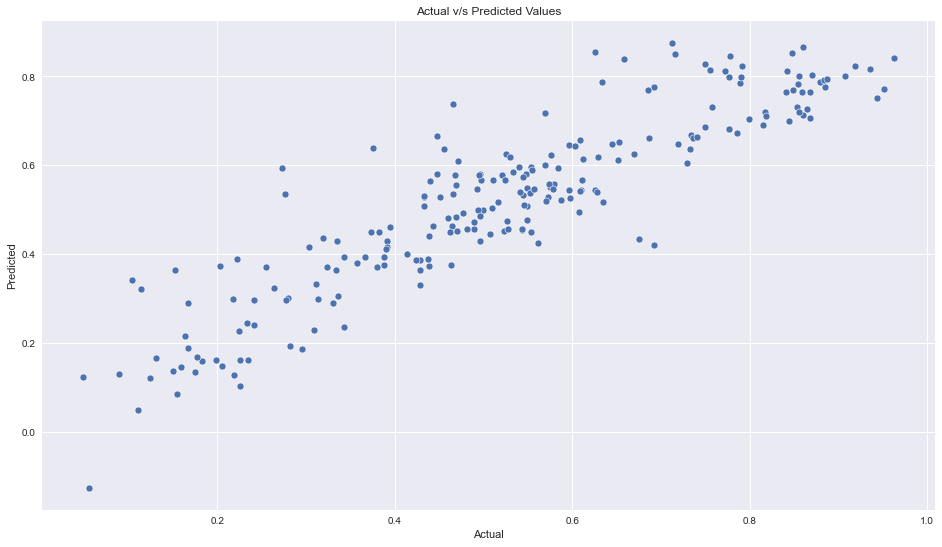

In [58]:
# Plotting the actual and predicted values of 'cnt' / target variable
axes = sns.scatterplot(y_test, y_test_pred);
# Setting the title and axes labels of chart
axes.set(title='Actual v/s Predicted Values', xlabel='Actual', ylabel='Predicted');

From the chart above, we can see that the predicted values and the actual values intest set are close and form a linear relation. Hence we can assume that the predictions are good. and model is performing well.
But we can confirm this performance with R2-score as well.

In [59]:
from sklearn.metrics import r2_score
# Calculate the r2score of on the test actual and predicted values
prediction_score = round(r2_score(y_true=y_test, y_pred=y_test_pred), 3)
prediction_score

0.812

*0.812 score indicates the correlation between the test data and the predicted values is strong. Hence we can be sure that the model is having a good performance.*

Now we can formulate our equation for the variable 'cnt' as:
<pre> cnt = 0.0902 * const + 0.2334 * yr +  0.0566 * workingday -0.0650 * spring + 0.0527 * summer + 0.0970 * winter -0.3041 * (Light Snow+Rain) -0.0786 * (Mist+Cloudy) 
+ 0.0916 * Sep + 0.0645 * Saturday + 0.4914 * temp </pre>